# The effect of errors in means, variances and covariances on optimal portfolio choice

## empirical exploration on the concepts of the paper

https://people.duke.edu/~charvey/Teaching/BA453_2006/Chopra_The_effect_of_1993.pdf

In [1]:
from main import run_analysis, setup_environment, PortfolioConfig, ExperimentConfig


In [29]:
# Celda 1: Importaciones y configuración inicial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from IPython.display import display, Markdown
from dataclasses import dataclass
from typing import Dict, List, Optional
import logging

# Configuración
np.random.seed(42)
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')


# 1. Creating simulated data
We will create simulated data similar to those in the paper, with 10 stocks and their respective parameters of expected returns, variances and covariances

In [ ]:
# Celda 2 Data from the paper
n_assets = 10
true_means = np.array([1.5617, 1.9477, 1.907, 1.5801, 2.1643, 
                       1.6010, 1.4892, 1.6248, 1.4075, 1.4537]) / 100
true_stds = np.array([8.8308, 8.4585, 10.040, 8.6215, 5.9886,
                      6.8767, 5.8162, 5.6385, 8.0047, 8.2125]) / 100
# Correlation matrix
base_corr = np.array([
    [1.0000, 0.3660, 0.3457, 0.1606, 0.2279, 0.5133, 0.5203, 0.2176, 0.3267, 0.5101],
    [0.3660, 1.0000, 0.5379, 0.2165, 0.4986, 0.5823, 0.3569, 0.4760, 0.6517, 0.5853],
    [0.3457, 0.5379, 1.0000, 0.2218, 0.4283, 0.4051, 0.4492, 0.3867, 0.4883, 0.6569],
    [0.1606, 0.2165, 0.2218, 1.0000, 0.0569, 0.3609, 0.2325, 0.2289, 0.1726, 0.3814],
    [0.2279, 0.4986, 0.4283, 0.0569, 1.0000, 0.3619, 0.4483, 0.5952, 0.4378, 0.4368],
    [0.5133, 0.5823, 0.4051, 0.3609, 0.3619, 1.0000, 0.6167, 0.4996, 0.5811, 0.5644],
    [0.5203, 0.3569, 0.4492, 0.2325, 0.4483, 0.6167, 1.0000, 0.6037, 0.5671, 0.6032],
    [0.2176, 0.4760, 0.3867, 0.2289, 0.5952, 0.4996, 0.6037, 1.0000, 0.5012, 0.4772],
    [0.3267, 0.6517, 0.4883, 0.1726, 0.4378, 0.5811, 0.5671, 0.5012, 1.0000, 0.6039],
    [0.5101, 0.5853, 0.6569, 0.3814, 0.4368, 0.5644, 0.6032, 0.4772, 0.6039, 1.0000]
])

# Covariance matrix
true_cov = np.outer(true_stds, true_stds) * base_corr


# 2. Optimization functions

We implement the necessary functions for portfolio optimization and the calculation of Cash Equivalent Loss (CEL)


In [31]:
def negative_utility(weights, means, cov, risk_tolerance):
    """
    Calculates the investor's 'discomfort' with the portfolio.
    More return -> Less discomfort
    More variance -> More discomfort
    More risk tolerance -> Variance bothers less
    """
    port_return = np.sum(weights * means)  # Fixed: changed 'weight' to 'weights'
    port_var = weights.T @ cov @ weights
    return -port_return + (1/(2*risk_tolerance)) * port_var

def optimize_portfolio(means, cov, risk_tolerance):
    """Optimizes the portfolio maximizing the mean-variance utility"""
    n = len(means)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = tuple((0, 1) for _ in range(n))

    result = minimize(
        negative_utility,
        x0=np.ones(n)/n,
        args=(means, cov, risk_tolerance),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result.x

def calculate_cel(true_weights, error_weights, means, cov, risk_tolerance):
    """Computes the cash equivalent loss between optimal and sub-optimal portfolios"""
    true_utility = -negative_utility(true_weights, means, cov, risk_tolerance)
    error_utility = -negative_utility(error_weights, means, cov, risk_tolerance)
    return (true_utility - error_utility)/ true_utility * 100


# Experiment 
## Impact of errors in estimation
We will analyze the impact of errors in estimation of means, variance, and covariance affect the portfolio's return

In [32]:
def generate_error_matrix(true_matrix, error_size, is_diagonal=False):
    """Genera matriz con errores aleatorios."""
    if is_diagonal:
        error = np.diag(true_matrix) * (1 + error_size * np.random.randn(true_matrix.shape[0]))
        result = true_matrix.copy()
        np.fill_diagonal(result, error)
        return result
    
    error = true_matrix * (1 + error_size * np.random.randn(*true_matrix.shape))
    return error

def run_single_trial(true_means, true_cov, error_size, risk_tolerance):
    # Portafolio base
    base_weights = optimize_portfolio(true_means, true_cov, risk_tolerance)
    
    # Error en medias
    error_means = generate_error_matrix(true_means, error_size)
    weights_mean_error = optimize_portfolio(error_means, true_cov, risk_tolerance)
    cel_means = calculate_cel(base_weights, weights_mean_error, true_means, true_cov, risk_tolerance)
    
    # Error en varianzas
    error_var_cov = true_cov.copy()
    np.fill_diagonal(error_var_cov, np.diag(true_cov) * (1 + error_size * np.random.randn(true_cov.shape[0])))
    weights_var_error = optimize_portfolio(true_means, error_var_cov, risk_tolerance)
    cel_vars = calculate_cel(base_weights, weights_var_error, true_means, true_cov, risk_tolerance)
    
    # Error en covarianzas
    error_cov_matrix = true_cov.copy()
    mask = ~np.eye(true_cov.shape[0], dtype=bool)
    error_cov_matrix[mask] *= (1 + error_size * np.random.randn(np.sum(mask)))
    weights_cov_error = optimize_portfolio(true_means, error_cov_matrix, risk_tolerance)
    cel_covs = calculate_cel(base_weights, weights_cov_error, true_means, true_cov, risk_tolerance)
    
    return cel_means, cel_vars, cel_covs

def run_experiment(error_size=0.10, risk_tolerance=50, n_trials=100):
    """
    Ejecuta el experimento de sensibilidad a errores en la estimación de parámetros.
    
    Args:
        error_size (float): Tamaño del error como fracción (default: 0.10)
        risk_tolerance (int): Nivel de tolerancia al riesgo (default: 50)
        n_trials (int): Número de simulaciones a ejecutar (default: 100)
    
    Returns:
        pd.DataFrame: DataFrame con los resultados de las simulaciones
    
    Raises:
        ValueError: Si los parámetros están fuera de rangos válidos
    """
    # Validación de parámetros
    if error_size <= 0 or error_size > 1:
        raise ValueError("error_size debe estar entre 0 y 1")
    if risk_tolerance <= 0:
        raise ValueError("risk_tolerance debe ser positivo")
    if n_trials <= 0:
        raise ValueError("n_trials debe ser positivo")

    results = {
        'means': [],
        'covariances': []
    }
    
    for _ in range(n_trials):
        cel_means, cel_covs = run_single_trial(
            true_means, true_cov, error_size, risk_tolerance
        )
        results['means'].append(cel_means)
        results['covariances'].append(cel_covs)
    
    return pd.DataFrame(results)

In [33]:
# Importaciones y configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from dataclasses import dataclass
from typing import Dict, List, Optional
import logging

# Configuración visual
plt.style.use('default')
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [34]:
# Definición de clases
@dataclass
class ExperimentConfig:
    """Configuración para los experimentos de sensibilidad."""
    risk_tolerances: List[int]
    error_size: float
    n_trials: int = 100
    
    def validate(self):
        """Valida los parámetros de configuración."""
        if not self.risk_tolerances:
            raise ValueError("Debe especificar al menos una tolerancia al riesgo")
        if not all(rt > 0 for rt in self.risk_tolerances):
            raise ValueError("Todas las tolerancias al riesgo deben ser positivas")
        if not 0 < self.error_size <= 1:
            raise ValueError("error_size debe estar entre 0 y 1")
        if self.n_trials <= 0:
            raise ValueError("n_trials debe ser positivo")

class ResultVisualizer:
    """Clase para visualizar resultados de experimentos de sensibilidad."""
    
    def __init__(self, results: Dict[int, pd.DataFrame], config: ExperimentConfig):
        self.results = results
        self.config = config
    
    def plot_distributions(self, figsize: tuple = (18, 6)) -> None:
        """
        Genera gráficos de caja para visualizar la distribución del CEL.
        """
        fig, axes = plt.subplots(1, len(self.config.risk_tolerances), figsize=figsize)
        
        if len(self.config.risk_tolerances) == 1:
            axes = [axes]
            
        fig.suptitle('Distribución del Cash Equivalent Loss por Tipo de Error y Tolerancia al Riesgo',
                    fontsize=12, y=1.05)
        
        for i, rt in enumerate(self.config.risk_tolerances):
            data = self.results[rt]
            sns.boxplot(data=data, ax=axes[i])
            axes[i].set_title(f'Tolerancia al Riesgo = {rt}', pad=10)
            axes[i].set_ylabel('CEL (%)' if i == 0 else '')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_summary_stats(self) -> None:
        """
        Genera y muestra estadísticas resumen de los resultados.
        """
        display(Markdown("## Resumen Estadístico del CEL"))
        
        for rt in self.config.risk_tolerances:
            display(Markdown(f"### Tolerancia al Riesgo = {rt}"))
            
            stats = self.results[rt].describe()
            stats_styled = stats.style.format("{:.4f}")
            display(stats_styled)
            
            means = self.results[rt].mean()
            ratios = pd.DataFrame({
                "Ratio": [
                    means['means']/means['covariances'],
                    means['means']/means['covariances'],
                    means['covariances']/means['covariances']
                ]
            }, index=['Medias/Varianzas', 'Medias/Covarianzas', 'Varianzas/Covarianzas'])
            
            display(Markdown("#### Ratios de Importancia"))
            ratios_styled = ratios.style.format("{:.4f}")
            display(ratios_styled)
            
            display(Markdown("---"))
    
    def plot_time_series(self, figsize: tuple = (15, 5)) -> None:
        """
        Genera un gráfico de series temporales para ver la evolución del CEL.
        """
        plt.figure(figsize=figsize)
        
        for rt in self.config.risk_tolerances:
            data = self.results[rt]
            plt.plot(data.index, data['means'], label=f'RT={rt}')
        
        plt.title('Evolución del CEL a lo largo de las simulaciones')
        plt.xlabel('Simulación')
        plt.ylabel('CEL (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


In [35]:
# Función de análisis
def run_sensitivity_analysis(config: ExperimentConfig) -> Dict[int, pd.DataFrame]:
    """
    Ejecuta el análisis de sensibilidad completo.
    """
    config.validate()
    logging.info(f"Iniciando análisis de sensibilidad con {len(config.risk_tolerances)} niveles de tolerancia")
    
    results = {}
    for rt in config.risk_tolerances:
        logging.info(f"Ejecutando experimento para tolerancia al riesgo {rt}")
        results[rt] = run_experiment(
            error_size=config.error_size,
            risk_tolerance=rt,
            n_trials=config.n_trials
        )
        logging.info(f"Completado experimento para RT={rt}")
    
    return results

In [36]:
# Ejecución del análisis
config = ExperimentConfig(
    risk_tolerances=[25, 50, 75],
    error_size=0.10,
    n_trials=100
)

all_results = run_sensitivity_analysis(config)
visualizer = ResultVisualizer(all_results, config)

2024-11-23 19:59:35,417 - Iniciando análisis de sensibilidad con 3 niveles de tolerancia
2024-11-23 19:59:35,425 - Ejecutando experimento para tolerancia al riesgo 25


ValueError: too many values to unpack (expected 2)

# Visualizaciones

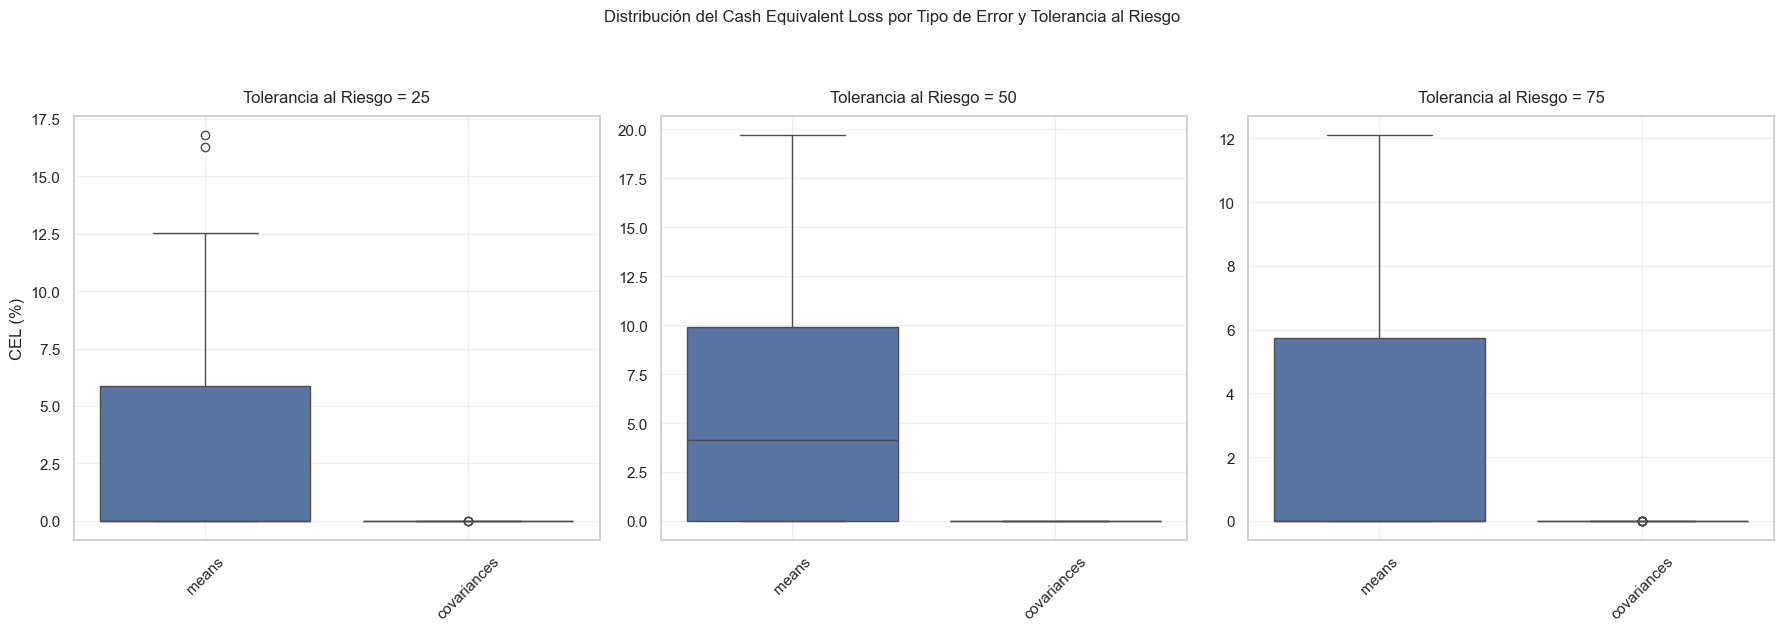

## Resumen Estadístico del CEL

### Tolerancia al Riesgo = 25

,means,covariances
count,100.0000,100.0000
mean,3.6944,0.0000
std,4.4608,0.0000
min,-0.0000,-0.0000
25%,-0.0000,-0.0000
50%,0.0000,0.0000
75%,5.8889,0.0000
max,16.7777,0.0000


#### Ratios de Importancia

,Ratio
Medias/Varianzas,765671249681452.1250
Medias/Covarianzas,765671249681452.1250
Varianzas/Covarianzas,1.0000


---

### Tolerancia al Riesgo = 50

,means,covariances
count,100.0000,100.0000
mean,4.6187,-0.0000
std,4.9489,0.0000
min,-0.0000,-0.0000
25%,-0.0000,-0.0000
50%,4.1159,-0.0000
75%,9.9266,-0.0000
max,19.7029,0.0000


#### Ratios de Importancia

,Ratio
Medias/Varianzas,-115985152868957.2500
Medias/Covarianzas,-115985152868957.2500
Varianzas/Covarianzas,1.0000


---

### Tolerancia al Riesgo = 75

,means,covariances
count,100.0000,100.0000
mean,3.4566,0.0000
std,4.4029,0.0000
min,-0.0000,-0.0000
25%,0.0000,0.0000
50%,0.0000,0.0000
75%,5.7457,0.0000
max,12.1018,0.0000


#### Ratios de Importancia

,Ratio
Medias/Varianzas,250450346971155.9688
Medias/Covarianzas,250450346971155.9688
Varianzas/Covarianzas,1.0000


---

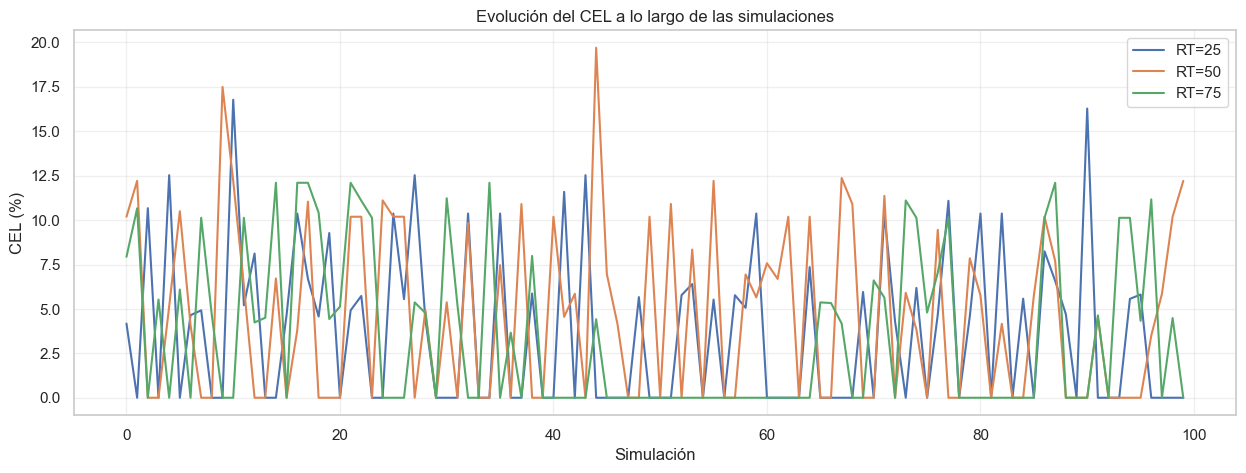

In [19]:
# Visualizaciones
visualizer.plot_distributions()
visualizer.generate_summary_stats()
visualizer.plot_time_series()

## Visualizaciones más claras

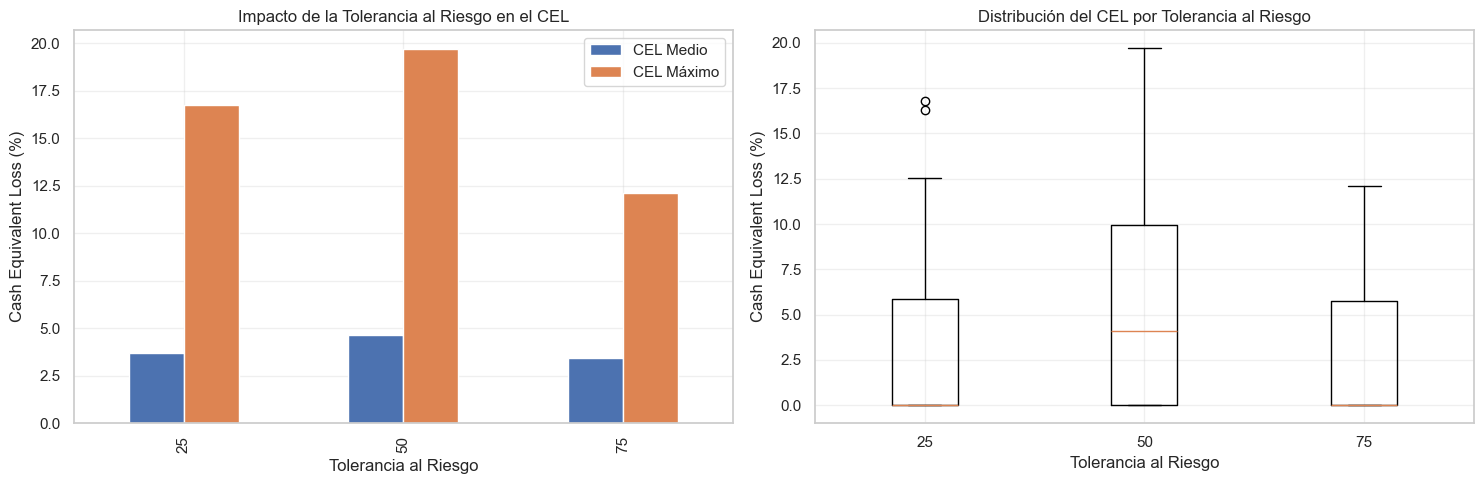

### Estadísticas Resumen por Nivel de Tolerancia al Riesgo

,CEL Medio,CEL Máximo,CEL Std,CEL Mediano
Tolerancia al Riesgo,,,,
25,3.6944,16.7777,4.4608,0.0000
50,4.6187,19.7029,4.9489,4.1159
75,3.4566,12.1018,4.4029,0.0000


In [21]:

def analyze_risk_tolerance_impact(all_results):
    # Crear un DataFrame con los resultados
    summary_stats = {}
    for rt in all_results.keys():
        stats = {
            'CEL Medio': all_results[rt]['means'].mean(),
            'CEL Máximo': all_results[rt]['means'].max(),
            'CEL Std': all_results[rt]['means'].std(),
            'CEL Mediano': all_results[rt]['means'].median()
        }
        summary_stats[rt] = stats
    
    df_summary = pd.DataFrame(summary_stats).T
    df_summary.index.name = 'Tolerancia al Riesgo'
    
    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico de barras para CEL medio y máximo
    df_summary[['CEL Medio', 'CEL Máximo']].plot(kind='bar', ax=ax1)
    ax1.set_title('Impacto de la Tolerancia al Riesgo en el CEL')
    ax1.set_ylabel('Cash Equivalent Loss (%)')
    ax1.grid(True, alpha=0.3)
    
    # Boxplot para la distribución completa
    data_to_plot = [all_results[rt]['means'] for rt in all_results.keys()]
    ax2.boxplot(data_to_plot, labels=list(all_results.keys()))
    ax2.set_title('Distribución del CEL por Tolerancia al Riesgo')
    ax2.set_xlabel('Tolerancia al Riesgo')
    ax2.set_ylabel('Cash Equivalent Loss (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df_summary

# Ejecutar el análisis
summary = analyze_risk_tolerance_impact(all_results)
display(Markdown("### Estadísticas Resumen por Nivel de Tolerancia al Riesgo"))
display(summary.style.format("{:.4f}"))


In [ ]:
# Visualizaciones más claras


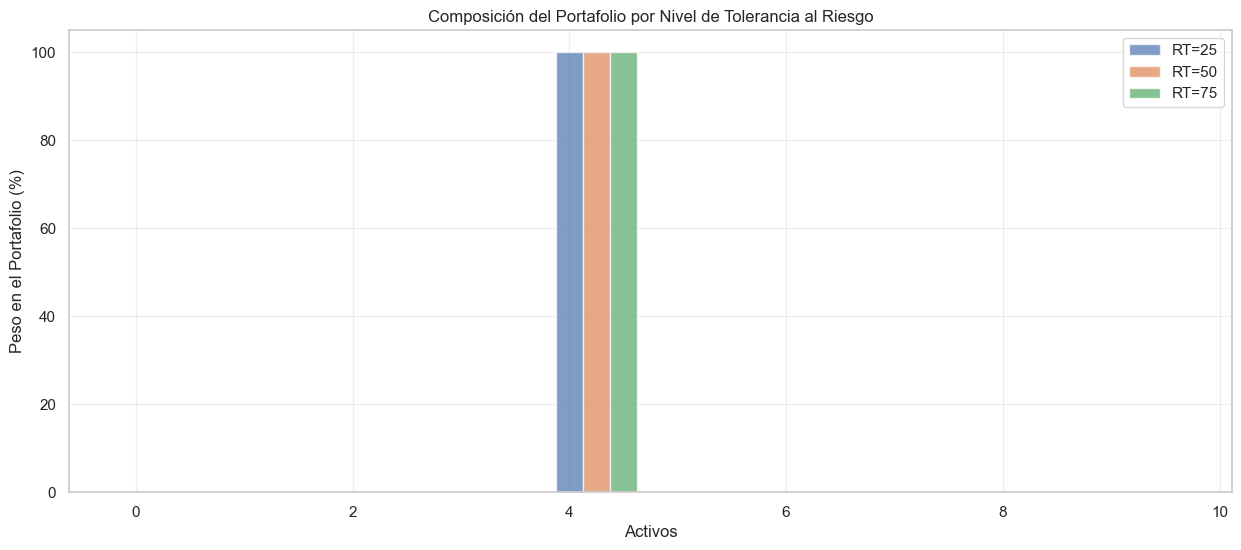


### Análisis de Perfiles de Inversión y Tolerancia al Riesgo

#### 1. Características del Portafolio por Nivel de RT:


,weights,return,risk,concentration,max_position,active_positions
Risk Tolerance,,,,,,
25,[1.29920785e-16 2.77555756e-17 5.45870000e-16 2.65255275e-17 1.00000000e+00 1.10394054e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00],2.16%,5.99%,1.000,100.0%,1
50,[0.00000000e+00 0.00000000e+00 1.09583828e-15 0.00000000e+00 1.00000000e+00 6.16435595e-17 0.00000000e+00 0.00000000e+00 1.16105808e-18 3.62135649e-18],2.16%,5.99%,1.000,100.0%,1
75,[9.01655936e-17 0.00000000e+00 0.00000000e+00 7.55024925e-17 1.00000000e+00 2.12671668e-16 1.23782789e-16 0.00000000e+00 1.15841684e-16 2.28883108e-17],2.16%,5.99%,1.000,100.0%,1


In [22]:

def analyze_portfolio_composition():
    '''Analiza cómo diferentes RT afectan la composición del portafolio'''
    # Calcular portafolios óptimos para diferentes RTs
    portfolios = {}
    for rt in [25, 50, 75]:
        weights = optimize_portfolio(true_means, true_cov, rt)
        portfolios[rt] = {
            'weights': weights,
            'return': np.sum(weights * true_means) * 100,  # Convertir a porcentaje
            'risk': np.sqrt(weights.T @ true_cov @ weights) * 100,  # Volatilidad en porcentaje
            'concentration': (weights ** 2).sum(),  # Índice Herfindahl
            'max_position': weights.max() * 100,  # Posición máxima en porcentaje
            'active_positions': np.sum(weights > 0.01)  # Número de posiciones > 1%
        }
    
    # Crear DataFrame con resultados
    df_profiles = pd.DataFrame(portfolios).T
    df_profiles.index.name = 'Risk Tolerance'
    
    # Visualización de la composición del portafolio
    plt.figure(figsize=(15, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(true_means)))
    
    bar_width = 0.25
    positions = np.arange(len(true_means))
    
    for i, rt in enumerate([25, 50, 75]):
        plt.bar(positions + i*bar_width, 
                portfolios[rt]['weights'] * 100, 
                bar_width,
                label=f'RT={rt}',
                alpha=0.7)
    
    plt.xlabel('Activos')
    plt.ylabel('Peso en el Portafolio (%)')
    plt.title('Composición del Portafolio por Nivel de Tolerancia al Riesgo')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return df_profiles

# Ejecutar análisis
portfolio_profiles = analyze_portfolio_composition()

# Mostrar resultados
display(Markdown("""
### Análisis de Perfiles de Inversión y Tolerancia al Riesgo

#### 1. Características del Portafolio por Nivel de RT:
"""))
display(portfolio_profiles.style.format({
    'return': '{:.2f}%',
    'risk': '{:.2f}%',
    'concentration': '{:.3f}',
    'max_position': '{:.1f}%',
    'active_positions': '{:.0f}'
}))

El modelo está encontrando una "solución de esquina"
Está ignorando los beneficios de la diversificación
No refleja las restricciones del mundo real
